# Competition

・[Systematic Review Work Shop-Peer Support Group (SRWS-PSG)](https://signate.jp/competitions/471)

# Evaluation

$\beta = 7$

$\text{FBetaScore} = \frac{(1 + \beta^{2}) \cdot \text{Precision} \cdot \text{Recall}}{\beta^{2} \cdot \text{Precision} + \text{Recall}}$

# Module

In [1]:
import gc
import scipy
import optuna
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Datasets

In [2]:
train = pd.read_csv('../input/systematic/train.csv')

print(train.shape)
train.head(10)

(27145, 4)


,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0
5,5,From bench to bedside: Molecular imaging in in...,Purpose of review Standard structural imaging ...,0
6,6,Left gonadal vein thrombosis in a patient with...,COVID-19 disease is a viral illness that predo...,0
7,7,Development and validation of a prediction mod...,OBJECTIVES: We aimed to develop and validate a...,0
8,8,Rehabilitation and Covid-19: the Cochrane Reha...,INTRODUCTION: This paper improves the methodol...,0
9,9,Slow gait in MCI is associated with ventricula...,Slow gait is ubiquitous among older adults and...,0


In [3]:
test = pd.read_csv('../input/systematic/test.csv')

print(test.shape)
test.head(10)

(40834, 3)


,id,title,abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,NaN
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...
5,27150,Anthraquinone Derivatives as an Immune Booster...,Anthraquinone derivatives are identified for t...
6,27151,Discriminatory and predictive capabilities of ...,BACKGROUND: Multiplex assays such as xMAP have...
7,27152,PET imaging of gliomas using novel tracers: A ...,NaN
8,27153,Symmetrical nail bed uptake on a (99m)Tc-HDP b...,NaN
9,27154,Automatic brain MR images diagnosis based on e...,A new automatic system to detect pathologies i...


In [4]:
submission = pd.read_csv('../input/systematic/sample_submit.csv')

print(submission.shape)
submission.head(10)

(40833, 2)


,27145,0
0,27146,1
1,27147,1
2,27148,0
3,27149,1
4,27150,0
5,27151,1
6,27152,1
7,27153,1
8,27154,1
9,27155,0


# Analytics

In [5]:
train.isnull().sum()

id              0
title           0
abstract     4390
judgement       0
dtype: int64

# Feature Engineering

In [6]:
sns.set()

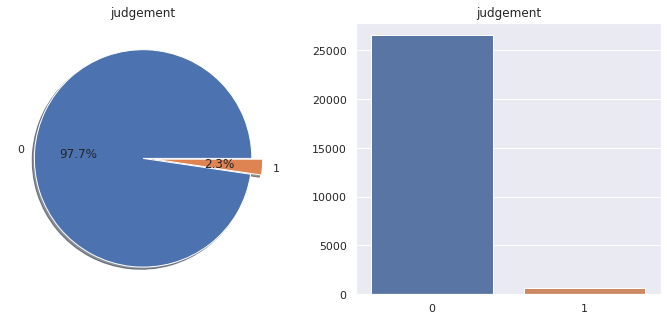

In [7]:
figure ,ax = plt.subplots(1, 2, figsize=(12,5))

train['judgement'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('judgement')
ax[0].set_ylabel('')

sns.countplot(x='judgement', data=train, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_ylabel('')
ax[1].set_title('judgement')

plt.show()

In [8]:
train['title_len'] = train['title'].apply(lambda x : len(x))
train['title_word_count'] = train['title'].apply(lambda x : len(x.split(' ')))

test['title_len'] = test['title'].apply(lambda x : len(x))
test['title_word_count'] = test['title'].apply(lambda x : len(x.split(' ')))

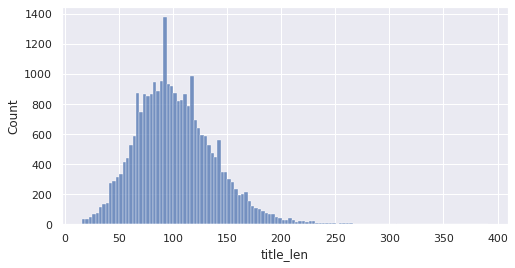

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['title_len'], ax=ax)
plt.show()

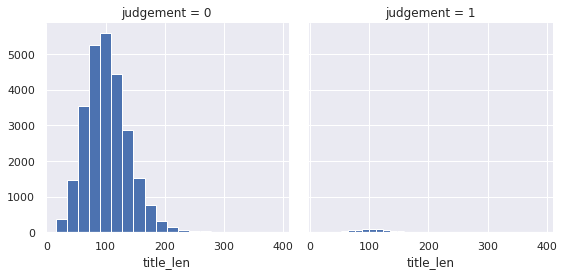

In [10]:
grid = sns.FacetGrid(train, col='judgement', height=4, aspect=1)
grid.map(plt.hist, 'title_len', bins=20)

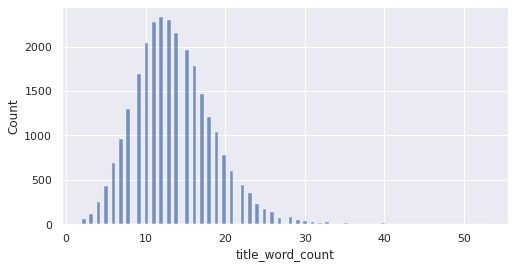

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['title_word_count'], ax=ax)
plt.show()

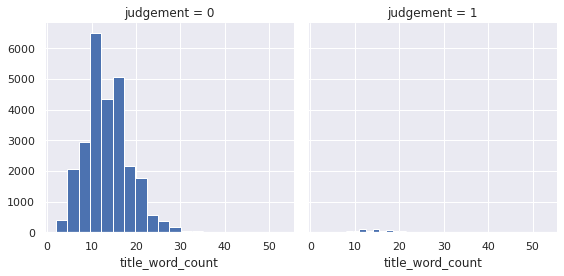

In [12]:
grid = sns.FacetGrid(train, col='judgement', height=4, aspect=1)
grid.map(plt.hist, 'title_word_count', bins=20)

In [13]:
train['abstract'] = train['abstract'].fillna('missing')
test['abstract'] = test['abstract'].fillna('missing')

In [14]:
train['abstract_len'] = train['abstract'].apply(lambda x : len(x))
train['abstract_word_count'] = train['abstract'].apply(lambda x : len(x.split(' ')))

test['abstract_len'] = test['abstract'].apply(lambda x : len(x))
test['abstract_word_count'] = test['abstract'].apply(lambda x : len(x.split(' ')))

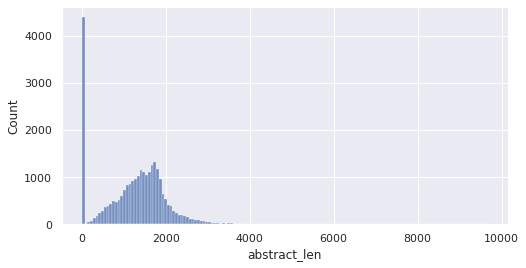

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['abstract_len'], ax=ax)
plt.show()

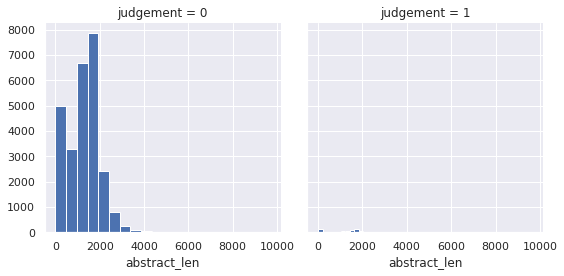

In [16]:
grid = sns.FacetGrid(train, col='judgement', height=4, aspect=1)
grid.map(plt.hist, 'abstract_len', bins=20)

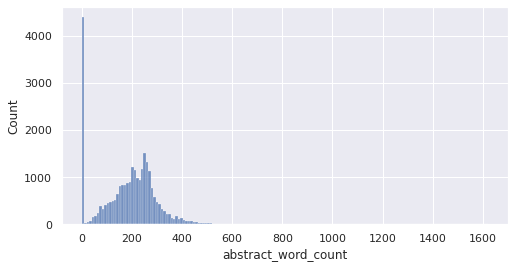

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(train['abstract_word_count'], ax=ax)
plt.show()

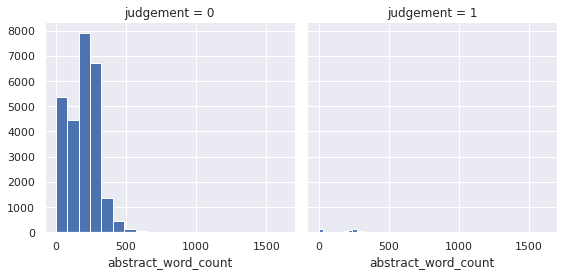

In [18]:
grid = sns.FacetGrid(train, col='judgement', height=4, aspect=1)
grid.map(plt.hist, 'abstract_word_count', bins=20)

# Preprocess

In [19]:
target = train['judgement']
train = train.drop(['id', 'judgement'], axis=1)

In [20]:
test_id = test['id']
test = test.drop('id', axis=1)

In [21]:
train_row = train.shape[0]

In [22]:
X = pd.concat([train, test], axis=0)

print(X.shape)
X.head()

(67979, 6)


,title,abstract,title_len,title_word_count,abstract_len,abstract_word_count
0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,58,10,1321,196
1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,182,23,1361,217
2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,59,10,1047,142
3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,87,13,2686,374
4,Prolonged shedding of SARS-CoV-2 in an elderly...,missing,107,16,7,1


In [23]:
X.isnull().sum()

title                  0
abstract               0
title_len              0
title_word_count       0
abstract_len           0
abstract_word_count    0
dtype: int64

In [24]:
cv = CountVectorizer()

title = cv.fit_transform(X['title'])
title

<67979x33078 sparse matrix of type '<class 'numpy.int64'>'
	with 918993 stored elements in Compressed Sparse Row format>

In [25]:
tv = TfidfVectorizer()

abstract = tv.fit_transform(X['abstract'])
abstract

<67979x107311 sparse matrix of type '<class 'numpy.float64'>'
	with 7096473 stored elements in Compressed Sparse Row format>

In [26]:
title_len = scipy.sparse.csr_matrix(pd.get_dummies(X['title_len'], sparse = True).values)
title_len

<67979x324 sparse matrix of type '<class 'numpy.uint8'>'
	with 67979 stored elements in Compressed Sparse Row format>

In [27]:
title_word_count = scipy.sparse.csr_matrix(pd.get_dummies(X['title_word_count'], sparse = True).values)
title_word_count

<67979x55 sparse matrix of type '<class 'numpy.uint8'>'
	with 67979 stored elements in Compressed Sparse Row format>

In [28]:
abstract_len = scipy.sparse.csr_matrix(pd.get_dummies(X['abstract_len'], sparse = True).values)
abstract_len

<67979x3509 sparse matrix of type '<class 'numpy.uint8'>'
	with 67979 stored elements in Compressed Sparse Row format>

In [29]:
abstract_word_count = scipy.sparse.csr_matrix(pd.get_dummies(X['abstract_word_count'], sparse = True).values)
abstract_word_count

<67979x700 sparse matrix of type '<class 'numpy.uint8'>'
	with 67979 stored elements in Compressed Sparse Row format>

In [30]:
X_sparse = scipy.sparse.hstack((title, abstract, title_len, title_word_count, abstract_len, abstract_word_count)).tocsr()
X_sparse

<67979x144977 sparse matrix of type '<class 'numpy.float64'>'
	with 8287382 stored elements in Compressed Sparse Row format>

In [31]:
train = X_sparse[:train_row]
test = X_sparse[train_row:]

In [32]:
del X, X_sparse, train_row, title, abstract, title_len, title_word_count, abstract_len, abstract_word_count

In [33]:
print(target.shape)
print(train.shape)
print(test.shape)

(27145,)
(27145, 144977)
(40834, 144977)


# Modeling

In [34]:
'''
X_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)

def create_model(trial):
    num_leaves = trial.suggest_int('num_leaves', 2, 30)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)
    max_depth = trial.suggest_int('max_depth', 2, 10)
    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)
    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)
    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)
    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)
      
    model = lgb.LGBMClassifier(
        num_leaves=num_leaves,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth, 
        min_child_samples=min_child_samples, 
        min_data_in_leaf=min_data_in_leaf,
        bagging_freq=bagging_freq,
        bagging_fraction=bagging_fraction,
        feature_fraction=feature_fraction,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=666)
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)
    logloss = log_loss(y_val, y_pred)
    return logloss

study = optuna.create_study()
study.optimize(objective, n_trials=40)
params = study.best_params
print(params)
'''

"\nX_tr, X_val, y_tr, y_val = train_test_split(train, target, test_size=0.2, random_state=666)\n\ndef create_model(trial):\n    num_leaves = trial.suggest_int('num_leaves', 2, 30)\n    n_estimators = trial.suggest_int('n_estimators', 50, 300)\n    learning_rate = trial.suggest_uniform('learning_rate', 0.0001, 0.99)\n    max_depth = trial.suggest_int('max_depth', 2, 10)\n    min_child_samples = trial.suggest_int('min_child_samples', 100, 1200)\n    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 5, 90)\n    bagging_freq = trial.suggest_int('bagging_freq', 1, 7)\n    bagging_fraction = trial.suggest_uniform('bagging_fraction', 0.0001, 1.0)\n    feature_fraction = trial.suggest_uniform('feature_fraction', 0.0001, 1.0)\n    subsample = trial.suggest_uniform('subsample', 0.1, 1.0)\n    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.1, 1.0)\n      \n    model = lgb.LGBMClassifier(\n        num_leaves=num_leaves,\n        n_estimators=n_estimators,\n        learning_r

In [35]:
params = {'num_leaves': 6,
          'n_estimators': 257,
          'learning_rate': 0.13941596320263555,
          'max_depth': 4,
          'min_child_samples': 458,
          'min_data_in_leaf': 43,
          'bagging_freq': 5,
          'bagging_fraction': 0.7835441569077518,
          'feature_fraction': 0.7376741168970312,
          'subsample': 0.26126173246283657,
          'colsample_bytree': 0.2318814498619885,
          'random_state': 666}

In [36]:
cls = lgb.LGBMClassifier(**params)
cls.fit(train, target)

[LightGBM] [Warning] bagging_fraction is set=0.7835441569077518, subsample=0.26126173246283657 will be ignored. Current value: bagging_fraction=0.7835441569077518
[LightGBM] [Warning] feature_fraction is set=0.7376741168970312, colsample_bytree=0.2318814498619885 will be ignored. Current value: feature_fraction=0.7376741168970312
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=458 will be ignored. Current value: min_data_in_leaf=43


LGBMClassifier(bagging_fraction=0.7835441569077518, bagging_freq=5,
               colsample_bytree=0.2318814498619885,
               feature_fraction=0.7376741168970312,
               learning_rate=0.13941596320263555, max_depth=4,
               min_child_samples=458, min_data_in_leaf=43, n_estimators=257,
               num_leaves=6, random_state=666, subsample=0.26126173246283657)

In [37]:
del train, target, params
gc.collect()

205

# Submit

In [38]:
prediction = cls.predict(test)

In [39]:
del test
gc.collect()

48

In [40]:
submit = pd.DataFrame(test_id, columns=['id'])
submit['judgement'] = prediction

submit.head(10)

,id,judgement
0,27145,0
1,27146,0
2,27147,0
3,27148,0
4,27149,0
5,27150,0
6,27151,0
7,27152,0
8,27153,0
9,27154,0


In [41]:
submit.to_csv('./submission.csv', index=False, header=None)